In [2]:
import yfinance as yfin

import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as pdr 
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings


warnings.filterwarnings("ignore")

yfin.pdr_override()

# List of stock symbols
ticker = 'MSFT'

# choose data over 2 years
start_date = '2019-1-1'
end_date = '2021-1-1'

# get the data with 1d interval 
stocks = pdr.get_data_yahoo(ticker, start_date, end_date,interval='1d')
stocks.dropna(inplace=True)


# get log percentage returns
stocks['Return'] = 100 * (stocks['Close'].pct_change())
stocks['Log_Return'] = np.log(stocks['Close']).diff().mul(100) # rescale to faciliate optimization
stocks = stocks.dropna()


[*********************100%%**********************]  1 of 1 completed


### Hurst Exponent

The Hurst Exponent is a statistical measure used to classify time series and infer the level of difficulty in predicting and choosing an appropriate model for the series at hand. The Hurst exponent is used as a measure of long-term memory of time series. It relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of values increases.

- Value near 0.5 indicates a random series.
- Value near 0 indicates a mean reverting series.
- Value near 1 indicates a trending series.

In [3]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# stats = f'ADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'

stat_test = adfuller(stocks['Return'].dropna())[0:2]
print(f"The test statistic and p-value of ADF test are {stat_test}")
if stat_test[1] < 0.05:
    print("The data is stationary")
else:
    print("The data is not stationary")

hurst_stat = round(hurst(stocks['Return'].values),2)

# print for different case of hurst_stat

print(f"The Hurst Exponent is {hurst_stat}")

The test statistic and p-value of ADF test are (-7.212097179922136, 2.221143548864747e-10)
The data is stationary
The Hurst Exponent is 0.02


The hurst exponent indicates the returns are mean reverting.

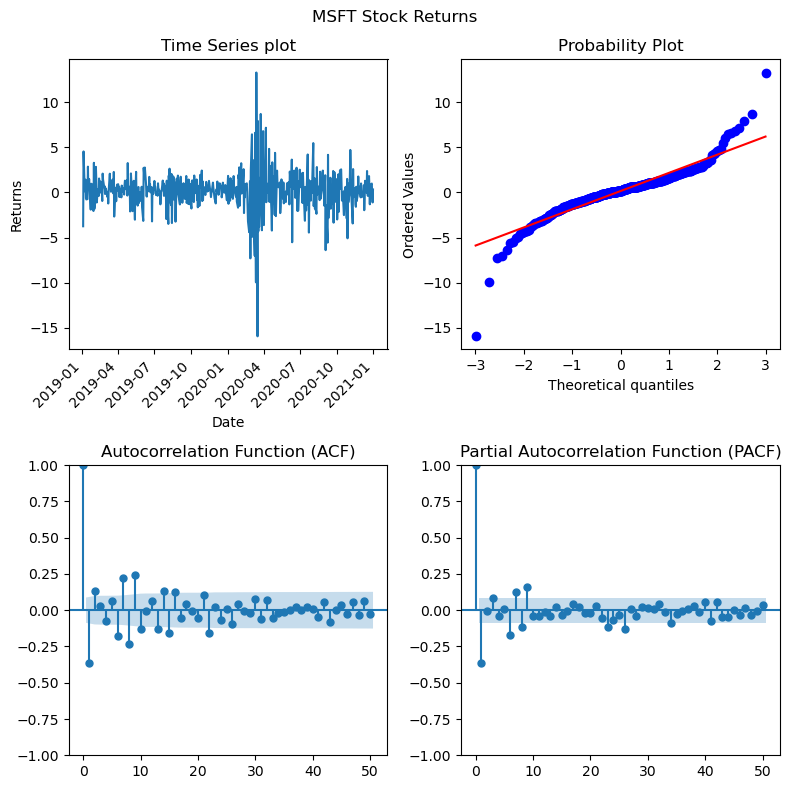

In [4]:
# Plottig the stock returns

def plot_stock_ts(ts,lags,title):

    mosaic = """
    AB
    CD
    """
    fig = plt.figure(figsize=(8,8))
    ax = fig.subplot_mosaic(mosaic)

    ax['A'].plot(ts)
    ax['A'].set_title("Time Series plot")
    ax['A'].set_xlabel("Date")
    ax['A'].set_ylabel("Returns")
    plt.setp(ax['A'].get_xticklabels(), rotation=45, ha="right")
    # Probability plot
    probplot(ts, plot=ax['B'])
    ax['B'].set_title("Probability Plot")

    # ACF plot
    plot_acf(ts, lags=lags, ax=ax['C'])
    ax['C'].set_title("Autocorrelation Function (ACF)")

    # PACF plot
    plot_pacf(ts, lags=lags, ax=ax['D'])
    ax['D'].set_title("Partial Autocorrelation Function (PACF)")

    fig.suptitle(f"{title}")
    plt.tight_layout()
    plt.show()


plot_stock_ts(stocks['Log_Return'], lags=50,title=f'{ticker} Stock Returns')


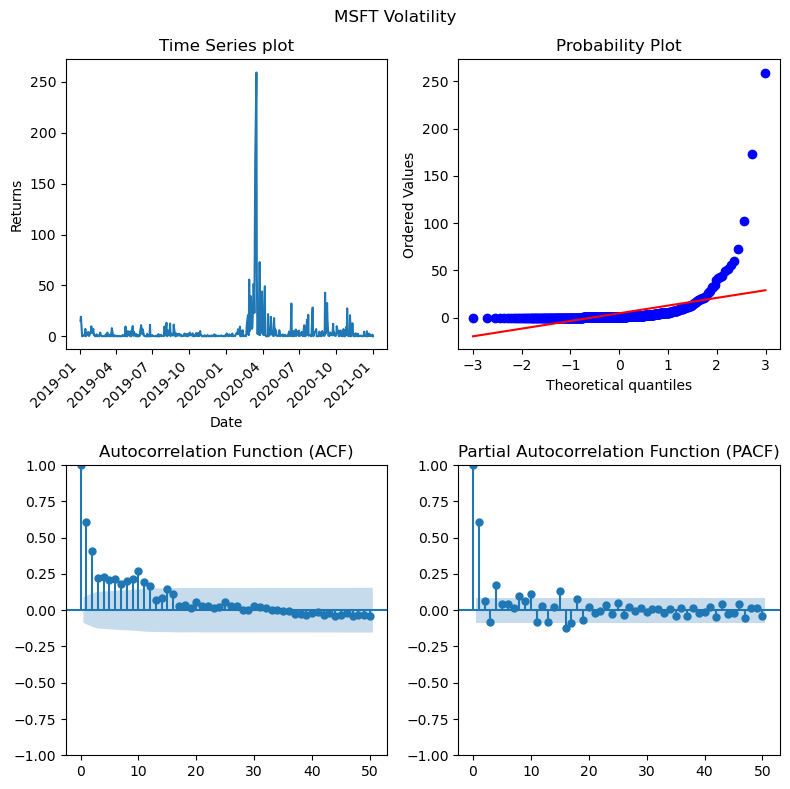

In [5]:
# calculate the volatility

stocks['sigma'] = stocks['Log_Return'].sub(stocks['Log_Return'].mean()).pow(2)

plot_stock_ts(stocks['sigma'], lags=50,title=f'{ticker} Volatility')

The volatility plot shows **volatility clustering** i.e. large changes tend is followed by large changes, of either sign, and small changes tend to be followed by small changes.

## GARCH(1,1) Models

GARCH(1,1) has only one parameter of each kind in it.
The equation has three constants: $\alpha$, $\beta$ and $\omega$. The $\omega$ parameter behaves like a con-
stant volatility you expect in a homoscedastic model while the $\alpha$ and $\beta$ parameters 
are a generalisation of the parameters in an exponentially weighted moving average model. 

The formula is:

$GARCH(1,1):\sigma_{t}^2=\omega+\alpha \epsilon^2_{t−1}+\beta \sigma^2_{t−1}$

Sometimes  the  constant  $\beta$  is  called  the  persistence 
because if it’s large, sharp rises in volatility take a long time to die down. The 
constant $\alpha$ is sometimes called the reaction because it determines how the volatility is affected by the latest return data.


In [6]:
basic_gm = arch_model(stocks['Return'], p = 1, q = 1,mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     30,   Neg. LLF: 959.7554704776599
Iteration:      8,   Func. Count:     52,   Neg. LLF: 957.4915252424339
Optimization terminated successfully    (Exit mode 0)
            Current function value: 957.4915252424339
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


In [7]:
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -957.492
Distribution:                  Normal   AIC:                           1922.98
Method:            Maximum Likelihood   BIC:                           1939.87
                                        No. Observations:                  504
Date:                Tue, Nov 21 2023   Df Residuals:                      503
Time:                        18:08:26   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1828  5.787e-02      3.158  1.588e-03 [6.935e-0

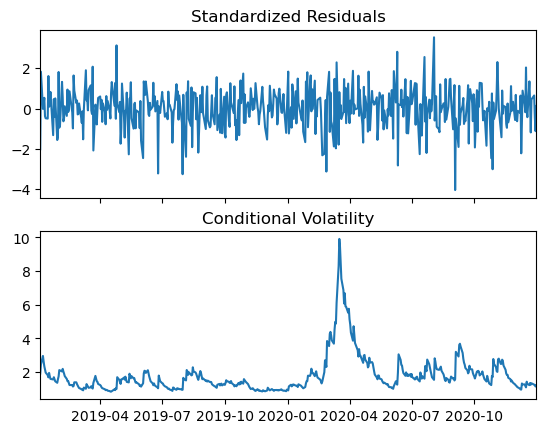

In [8]:
# Plot fitted results
gm_result.plot()
plt.show()

<Axes: xlabel='Date'>

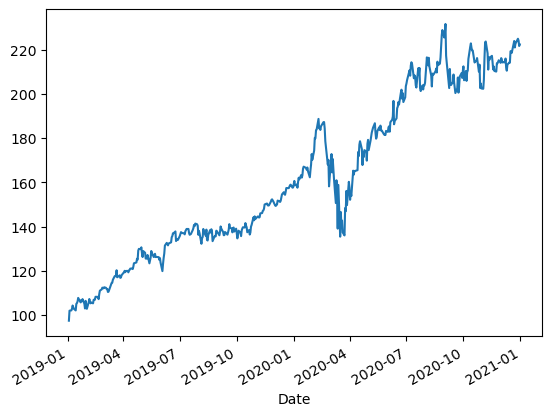

In [9]:
stocks.Close.plot()

### Forcasting with GARCH


In [10]:

# Make prediction for coming week
gm_forecast = gm_result.forecast(horizon = 5)

# variance for next days
print(gm_forecast.variance)

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2020-12-31  1.249168  1.335849  1.420332  1.502671  1.582922


### Distribution of residuals

GARCH models assumes that we have standardised residuals (residual / return volatility) have stadard normal distribution. 

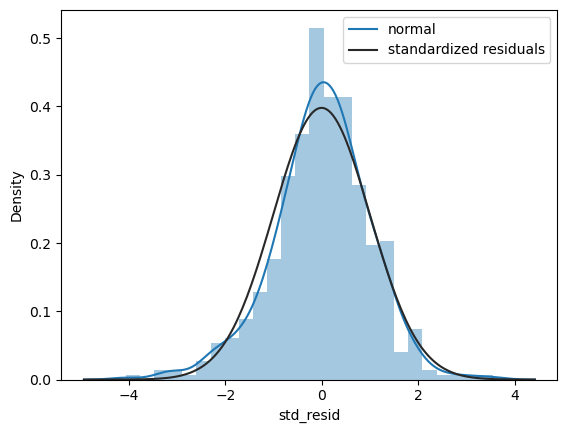

In [11]:
import seaborn as sns 

sns.distplot(gm_result.std_resid,norm_hist=True, fit=stats.norm)
plt.legend(('normal', 'standardized residuals'))
plt.show()

We observe that the standardized residuals have fatter tails and are not modelled well by the assumption of normal distribution. We can try to model residuals using t-distribution which has fatter tails.

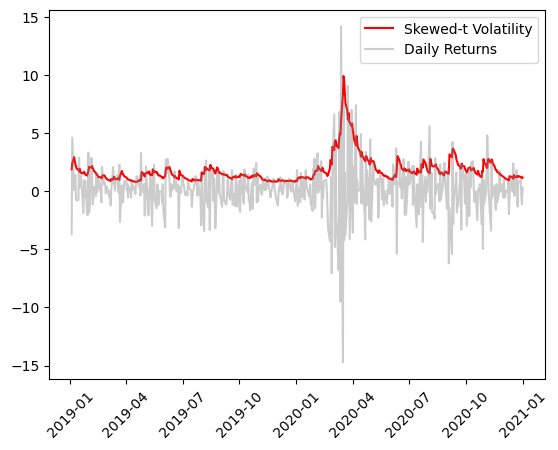

In [12]:
# Specify GARCH model assumptions
skewt_gm = arch_model(stocks['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility
# Plot model fitting results
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(stocks['Return'], color = 'grey', 
        label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')

plt.xticks(rotation = 45)
plt.show()

## ARMA + ARCH Modeling

In the my previous analysis in the notebook Time_series_analysis.ipynb we discussed ARMA modeling.
In the following section I am going to model the stock price using the ARIMA model I used in that notebook.
I model the log stock returns using ARIMA followed by fitting the residuals with ARCH model.

In [13]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


model = auto_arima(stocks['Log_Return'], start_p=0, start_q=0,
            test='adf',       
            max_p=12, max_q=12,             
            d=0,           
            seasonal=False, 
            trace=True,
            error_action='ignore',  
            suppress_warnings=True, 
            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2206.512, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2139.662, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2150.511, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2141.603, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2141.624, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2142.771, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2135.849, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2205.851, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2137.849, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2137.849, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2146.069, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2139.568, Time=0.43 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.224 seconds


In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  504
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1064.925
Date:                Tue, 21 Nov 2023   AIC                           2135.849
Time:                        18:08:29   BIC                           2148.517
Sample:                             0   HQIC                          2140.818
                                - 504                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2163      0.092      2.349      0.019       0.036       0.397
ar.L1         -0.3657      0.020    -18.260      0.000      -0.405      -0.326
sigma2         4.0057      0.132     30.431      0.000       3.748       4.264
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               949.69
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11872D+00    |proj g|=  2.01057D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.366D-06   2.119D+00
  F =   2.1187120324682827     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


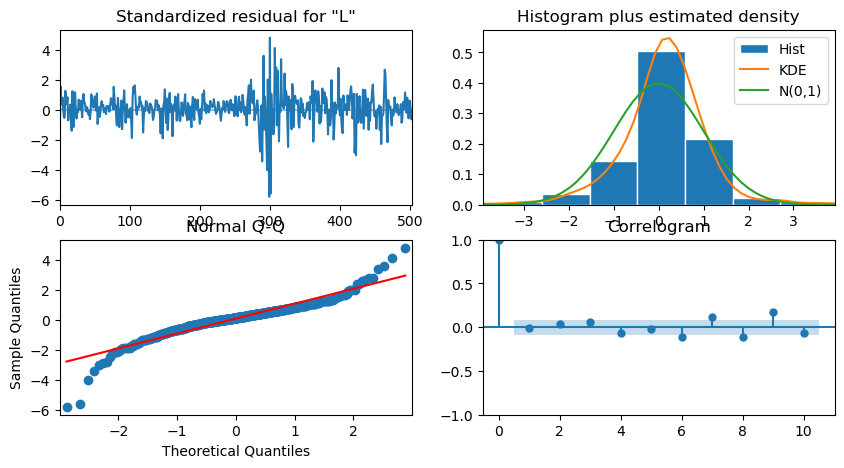

In [15]:
# Fit best model
_arma_model = sm.tsa.SARIMAX(endog=stocks['Log_Return'],order=(1, 0, 0))
_model_result = _arma_model.fit()
# Plot model residuals
_model_result.plot_diagnostics(figsize=(10, 5))
plt.show()

In [16]:
# Fit GARCH model with ARMA model residuals
_garch_model = arch_model(_model_result.resid, mean='Zero', p=1, q=1)
_garch_result = _garch_model.fit(disp = 'off')
print(_garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -970.589
Distribution:                  Normal   AIC:                           1947.18
Method:            Maximum Likelihood   BIC:                           1959.85
                                        No. Observations:                  504
Date:                Tue, Nov 21 2023   Df Residuals:                      504
Time:                        18:08:29   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1172  5.148e-02      2.277  2.276e-02 [1.634e-0

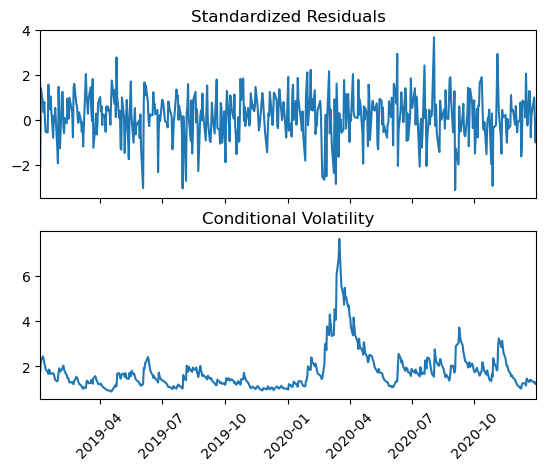

In [17]:
# Plot GARCH model fitted results
_garch_result.plot()
plt.xticks(rotation = 45)
plt.show()

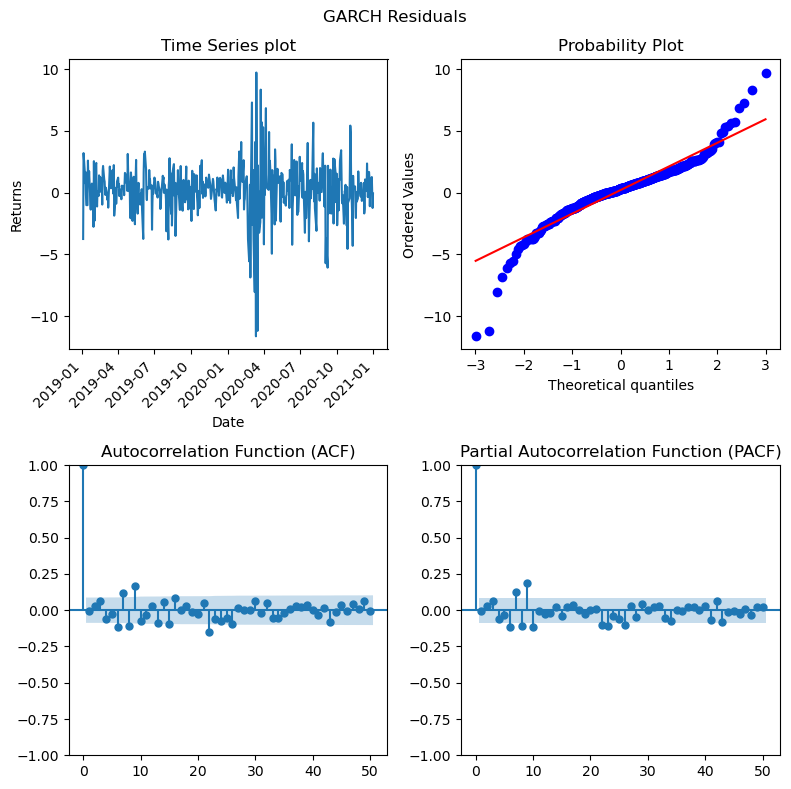

In [18]:
plot_stock_ts(_garch_result.resid.dropna(), lags=50, title='GARCH Residuals')


## Information assymetry

Vanilla GARCH assumes the bad and good news to affect the price market response equally which might not be the case due to leverage effect. As the stock prices go down (in case of bad news) the debt-to-equity ratio (DER) of the company goes up and the stock becomes risky. People try to minimise thier risk in such a situation resulting in skewed response in case of bad news. Negative news tends to affect the volatility more than positive news.

Two models that can deal with the information assymmetry are GJR-GARCH and EGARCH (Exponential GARCH)





### GJR GARCH

If the conditional variance of the GARCH(1,1) model at time $ t $ as $ h_t $, and the corresponding conditional standard deviation as $ \sigma_t $. The basic GARCH(1,1) model can be represented by the following equations:


\begin{align*}
h_t &= \omega + \alpha \cdot \varepsilon_{t-1}^2 + \beta \cdot h_{t-1} \\
\sigma_t &= \sqrt{h_t}
\end{align*}


Here:
- $\omega $ is a constant term,
- $\alpha $ and $ \beta $ are coefficients,
- $\varepsilon_{t-1} $ is the lagged (previous time step) standardized residual.

The GJR GARCH(1,1) model introduces an additional parameter $ \gamma $ to account for asymmetry. The formulation is as follow$


\begin{align*}
h_t &= \omega + \alpha \cdot \varepsilon_{t-1}^2 + \beta \cdot h_{t-1} + \gamma \cdot \varepsilon_{t-1}^2 \cdot I_{\{\varepsilon_{t-1} < 0\}} \\
\sigma_t &= \sqrt{h_t}
\end{align*}


Here:
- $ I_{\{\varepsilon_{t-1} < 0\}} $ is an indicator function that equals 1 if $ \varepsilon_{t-1} < 0 $ and 0 otherwise.
- The additional term $ \gamma \cdot \varepsilon_{t-1}^2 \cdot I_{\{\varepsilon_{t-1} < 0\}} $ captures the asymmetry by allowing the impact of negative shocks to differ from positive shocks.

This modification allows the GJR GARCH model to account for the fact that volatility may respond differently to positive and negative shocks. 

In [31]:
# Specify GJR-GARCH model assumptions
gjr_gm = arch_model(stocks['Log_Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -948.549
Distribution:      Standardized Student's t   AIC:                           1909.10
Method:                  Maximum Likelihood   BIC:                           1934.43
                                              No. Observations:                  504
Date:                      Tue, Nov 21 2023   Df Residuals:                      503
Time:                              18:19:44   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

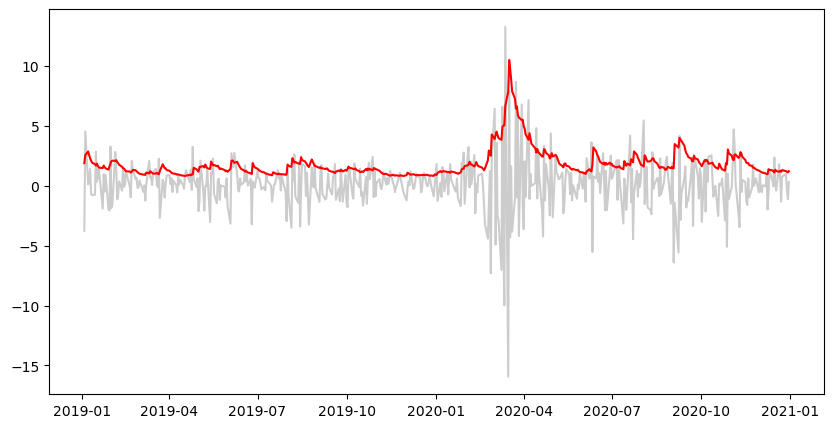

In [33]:
# Plot the Returns in grey and GJR-GARCH in red

fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(stocks['Log_Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')
ax.plot(gjrgm_result.conditional_volatility, color = 'red', label = 'GJR-GARCH')

### Exponential GARCH (EGARCH)

The Exponential Generalized Autoregressive Conditional Heteroskedasticity (EGARCH) model, like the GARCH model, is used to model and forecast volatility in financial time series data. The key distinction lies in how they model the conditional variance.

The GARCH model assumes that volatility responds symmetrically to positive and negative shocks. On the other hand, the EGARCH model allows for asymmetric responses by modeling the logarithm of conditional variance. The EGARCH(1,1) model can be expressed as follows:

$ \log(h_t) = \omega + \alpha |\varepsilon_{t-1}| + \beta \log(h_{t-1}) $

Here:
- $\omega $ is a constant term,
- $\alpha $ and $ \beta $ are coefficients,
- $\varepsilon_{t-1} $ is the lagged (previous time step) standardized residual.

The key difference is the term $ \alpha |\varepsilon_{t-1}| $, where $ |\varepsilon_{t-1}| $ is the absolute value of the lagged standardized residual. This term allows for a direct and asymmetric impact of past shocks on the conditional variance.

Therefore, EGARCH model incorporates asymmetry in volatility more explicitly than the GARCH model by using the absolute value of past shocks in the formulation. 

In [34]:
# Specify EGARCH model assumptions
egarch_gm = arch_model(stocks['Log_Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')

# Print model fitting summary
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -949.202
Distribution:      Standardized Student's t   AIC:                           1910.40
Method:                  Maximum Likelihood   BIC:                           1935.74
                                              No. Observations:                  504
Date:                      Tue, Nov 21 2023   Df Residuals:                      503
Time:                              18:26:01   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

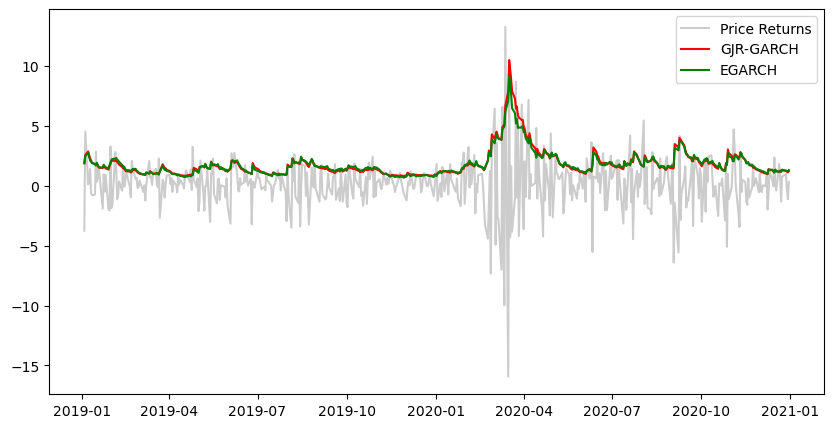

In [35]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(stocks['Log_Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')
ax.plot(gjrgm_result.conditional_volatility, color = 'red', label = 'GJR-GARCH')
ax.plot(egarch_result.conditional_volatility, color = 'green', label = 'EGARCH')

ax.legend()

In [36]:
# Print each models BIC
print(f'GJR-GARCH BIC: {gjrgm_result.bic}')
print(f'\nEGARCH BIC: {egarch_result.bic}')

GJR-GARCH BIC: 1934.4340308161097

EGARCH BIC: 1935.738730969512


Both models performed well in computing the volatility of the stock prices but GJR-GARCH yeilds a little better estimates compared to EGARCH.